# Задача 3. Сравнение методов классификации

In [1]:
import heapq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

## Собственные реализации

### Метод опорных векторов

In [2]:
class MySVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            if y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Логистическая линейная регрессия методом градиентного спуска

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, learning_rate=0.01, iter_num=1000, batch_size=None, C=1.0):
        self.weights = None
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.batch_size = batch_size
        self.C = C

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.c_[np.ones(n_samples), X]

        self.weights = np.random.randn(n_features + 1)

        for _ in range(self.iter_num):
            if self.batch_size is None:
                X_batch = X
                y_batch = y
            else:
                indices = np.random.choice(n_samples, self.batch_size)
                X_batch = X[indices]
                y_batch = y[indices]

            predictions = self.sigmoid(X_batch @ self.weights)
            gradients = X_batch.T @ (predictions - y_batch) / n_samples

            regularization_term = self.weights / n_samples / self.C
            regularization_term[0] = 0  # Do not regularize the bias term
            gradients += regularization_term

            self.weights -= self.learning_rate * gradients

    def predict_proba(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return self.sigmoid(X @ self.weights)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

## Набор данных "Заболевания сердца"

In [4]:
df = pd.read_csv('heart.csv')

Описание набора данных:

  - `age` - age in years
  - `sex` - (1 = male; 0 = female)
  - `cp` - chest pain type
  - `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
  - `chol` - serum cholestoral in mg/dl
  - `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
  - `restecg` - resting electrocardiographic results
  - `thalach` - maximum heart rate achieved
  - `exang` - exercise induced angina (1 = yes; 0 = no)
  - `oldpeak` - ST depression induced by exercise relative to rest
  - `slope` - the slope of the peak exercise ST segment
  - `ca` - number of major vessels (0-3) colored by flourosopy
  - `thal` - 3 = normal; 6 = fixed defect; 7 = reversable defect
  - `target` - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целевой признак `target`, имеет ли пациент заболевание сердца.

### EDA

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


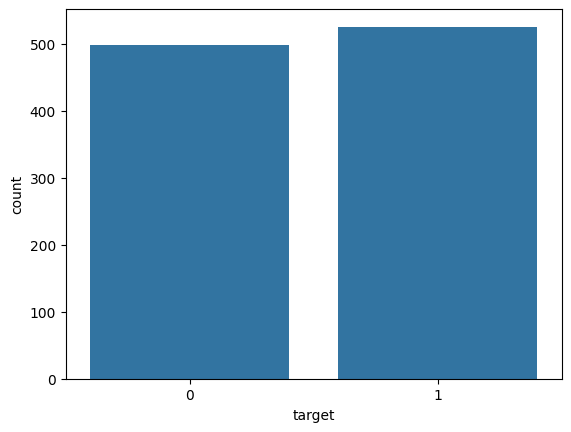

In [6]:
sns.countplot(x="target", data=df)
plt.show()

Делаем вывод, что датасет сбалансирован.

Закодируем категориальные признаки и стандартизируем диапозоны:

In [7]:
categorical_features = ['cp', 'restecg', 'thal', 'slope']

df = pd.concat(
  [df.drop(columns=categorical_features), pd.get_dummies(df[categorical_features].astype(str), drop_first=True)],
  axis=1
)

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

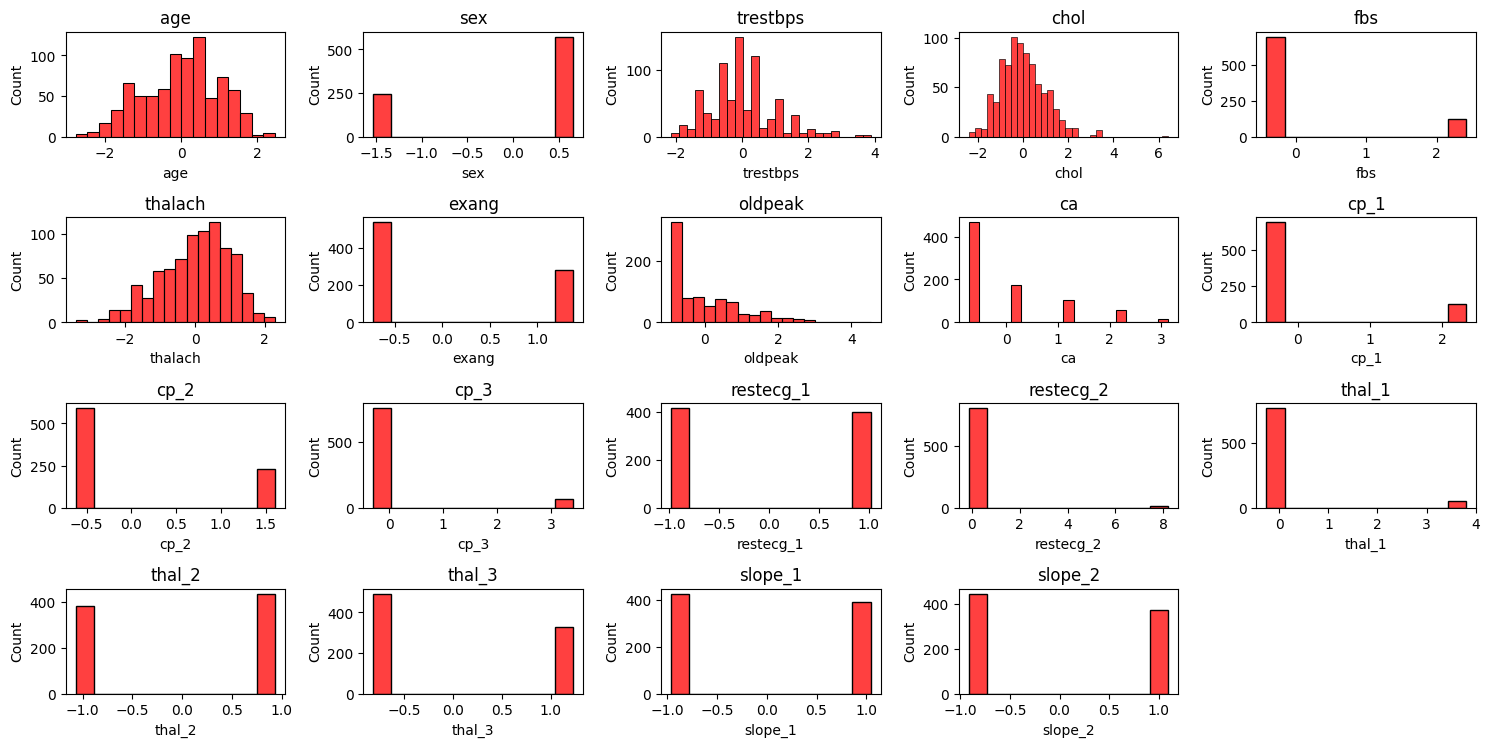

In [8]:
features = df.columns.drop('target')

plt.figure(figsize=(15, 9))
for i, feature in enumerate(features):
    plt.subplot(5, 5, i + 1)
    sns.histplot(X_train[feature], kde=False, edgecolor='black', color='red')
    plt.title(feature)
    plt.tight_layout()

plt.show()

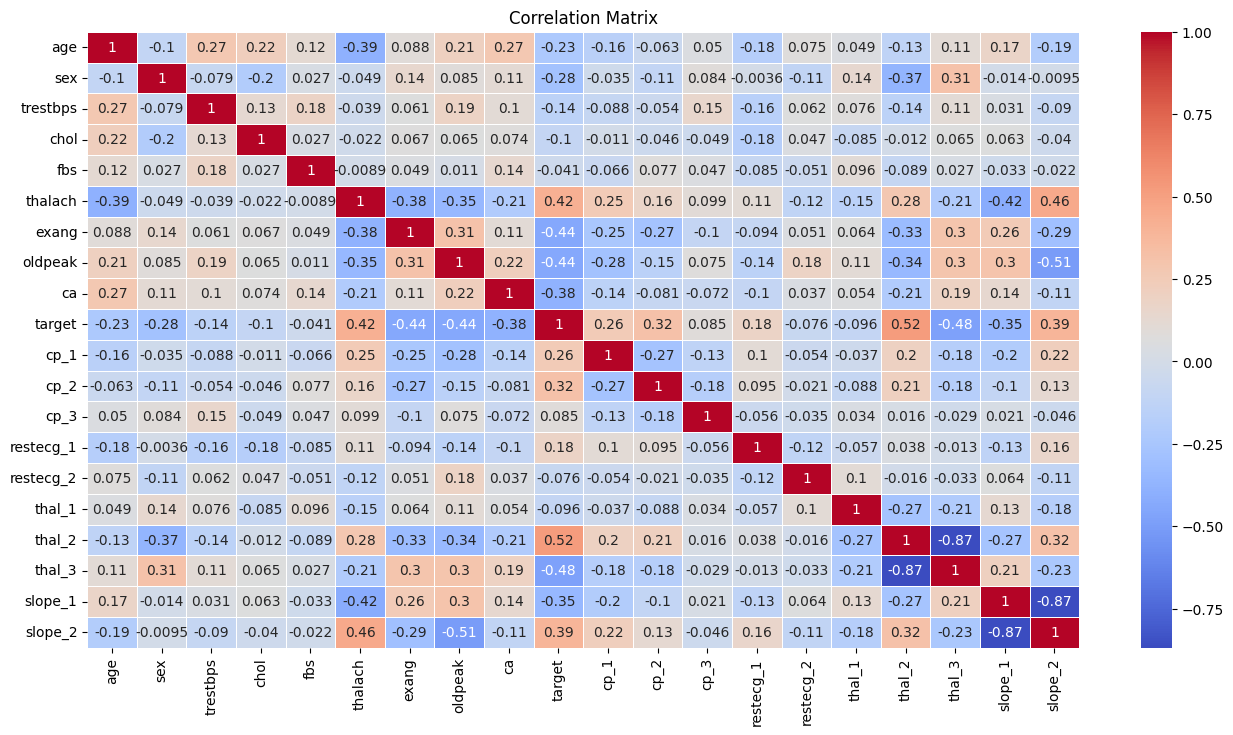

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Оставляем все признаки ввиду отсутствия сильно кореллирующих.

### Сравнение

Сравним на наборе данных "Заболевания сердца" собственные реализации `MyLogisticRegression` и `MySVMClassifier` и библиотечные реализации `LogisticRegression`, `SVC`, `KNeighborsClassifier`, `GaussianNB` и `DecisionTreeClassifier`. Будем использовать подбор гиперпараметров с кросс-валидацией.

In [10]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
def train_evaluate_model(model, params):
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    print(f"Model: {best_model.__class__.__name__}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Train Score: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Score: {accuracy_score(y_test, y_pred_test):.4f}")
    print()

    return confusion_matrix(y_test, y_pred_test)

In [12]:
models = {
    'MyLogisticRegression': (MyLogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0], 'iter_num': [1000, 2000, 4000]}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'liblinear']}),
    'MySVMClassifier': (MySVMClassifier(), {'learning_rate': [0.1, 0.001, 0.0005], 'iter_num': [100, 1000, 3000], 'lmda': [0.1, 0.001, 0.0005]}),
    'SVM': (SVC(), {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto', 0.1, 1, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}),
    'NaiveBayes': (GaussianNB(), {}),
    'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [None, 3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
}

In [13]:
def train_models():
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
  for ax, (name, (model, params)) in zip(axes.flatten(), models.items()):
    cm = train_evaluate_model(model, params)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.title.set_text(f'{model.__class__.__name__}')
    
  fig.delaxes(axes[1, 3])
  plt.tight_layout()
  plt.show()

Model: MyLogisticRegression
Best Params: {'C': 100, 'iter_num': 4000, 'learning_rate': 0.1}
Train Score: 0.8817
Test Score: 0.8098

Model: LogisticRegression
Best Params: {'C': 10, 'solver': 'newton-cg'}
Train Score: 0.8817
Test Score: 0.8098

Model: MySVMClassifier
Best Params: {'iter_num': 100, 'learning_rate': 0.0005, 'lmda': 0.1}
Train Score: 0.8427
Test Score: 0.7902

Model: SVC
Best Params: {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
Train Score: 1.0000
Test Score: 0.9854

Model: KNeighborsClassifier
Best Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Train Score: 1.0000
Test Score: 1.0000

Model: GaussianNB
Best Params: {}
Train Score: 0.8537
Test Score: 0.8000

Model: DecisionTreeClassifier
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Score: 1.0000
Test Score: 1.0000



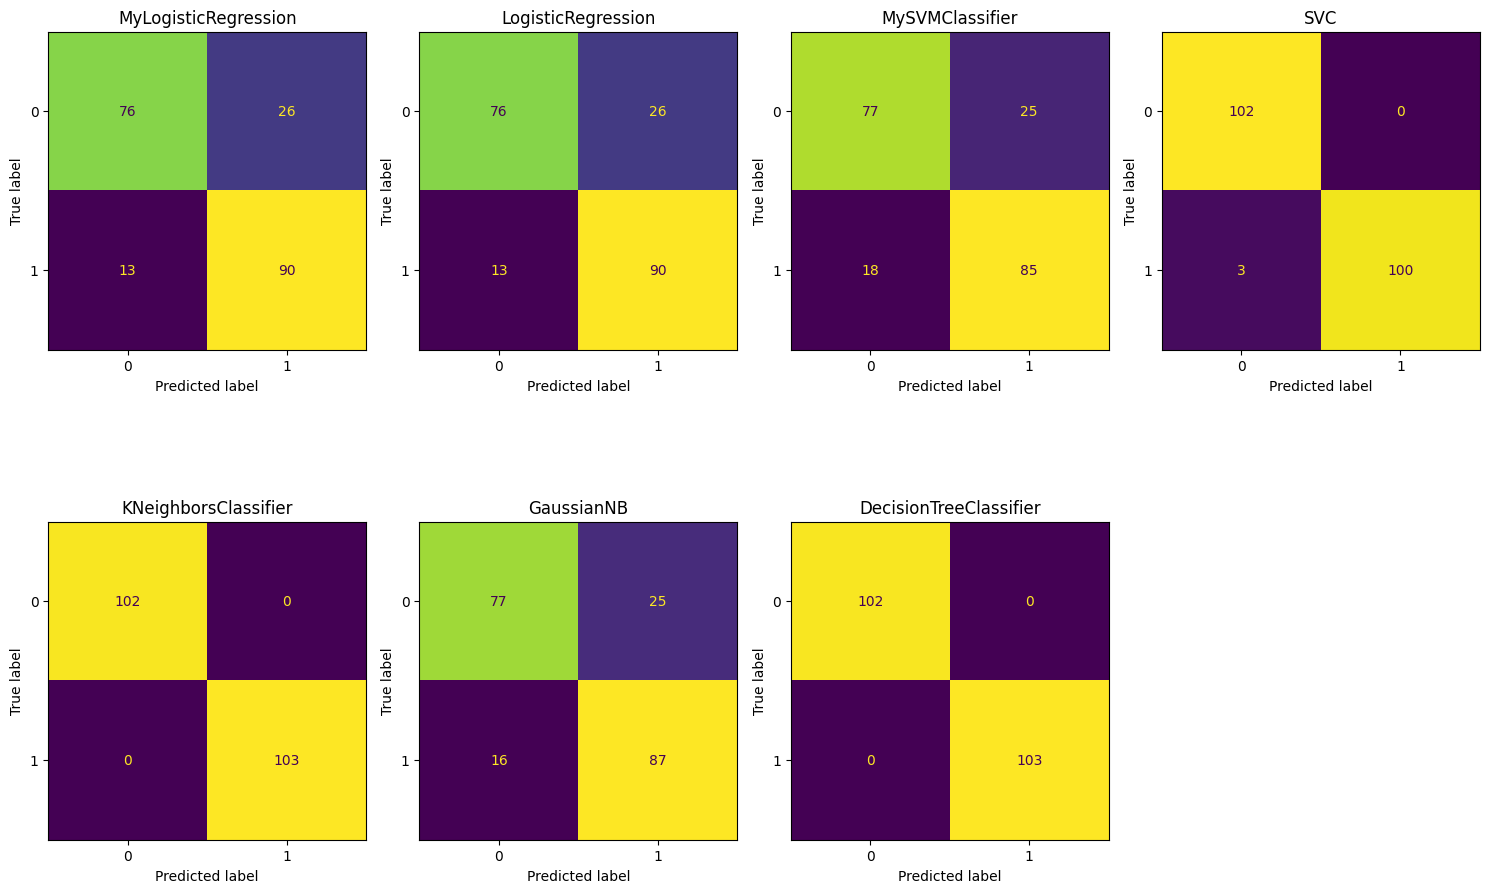

In [14]:
train_models()

Наилучшие результаты показали классификаторы `KNeighborsClassifier`, `DecisionTreeClassifier` и `SVC`. При этом, собственная реализация логистической регрессии показала фактически идентичный результат с библиотечной реализацией этого алгоритма.

## Набор данных "Мошеннические транзакции"

In [24]:
df = pd.read_csv('creditcard_2023.csv')

Описание набора данных:

  - `id` - Unique identifier for each transaction
  - `V1-V28` - Anonymized features representing various transaction attributes (e.g., time, location, etc.)
  - `Amount` - The transaction amount
  - `Class` - Binary label indicating whether the transaction is fraudulent (1) or not (0)

Необходимо решить задачу классификации и научиться предсказывать целевой признак `Class`, является ли транзакция мошеннической.

Так как датасет содержит более 550000 записей, для разумного времени проведеня экспериментов возьмем первые каждую 100-ую запись:

In [25]:
df = df.iloc[::100, :]

### EDA

In [26]:
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
100,100,0.956448,-0.431989,0.781047,-0.400616,0.081812,0.269329,0.360036,-0.116316,0.501603,...,-0.177250,-0.583302,0.178605,0.379961,-0.031124,0.238485,-0.268247,-0.089963,21927.91,0
200,200,-0.313757,0.068943,0.896567,-0.112850,0.172228,0.474492,0.485007,-0.032342,0.283618,...,-0.083770,0.313221,-0.054537,0.265534,-0.181792,-0.703701,-0.741265,-0.506871,12944.09,0
300,300,-0.500386,-0.961321,2.205174,0.122561,1.202822,-0.306842,0.077715,-0.103730,0.582793,...,-0.139329,0.103684,-0.633490,1.036683,0.362748,-0.203298,0.163593,-0.236457,6292.85,0
400,400,-0.068335,-0.255720,2.326944,-0.596650,0.389750,0.210875,0.963196,-0.317086,0.739254,...,-0.237139,-0.374051,-0.444758,0.891367,0.303131,0.445657,-0.953843,-1.610952,18359.14,0


Уберём лишнюю колонку `id`:

In [27]:
df = df.drop(columns=["id"])

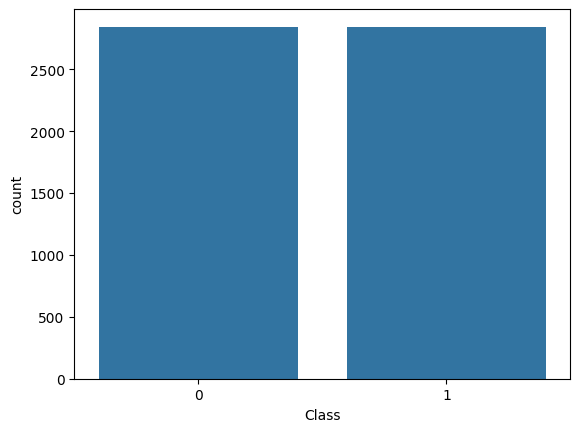

In [28]:
sns.countplot(x="Class", data=df)
plt.show()

Делаем вывод, что датасет сбалансирован.

В датасете отсутствуют категориальные признаки, за исключением целевого: кодирование не требуется.

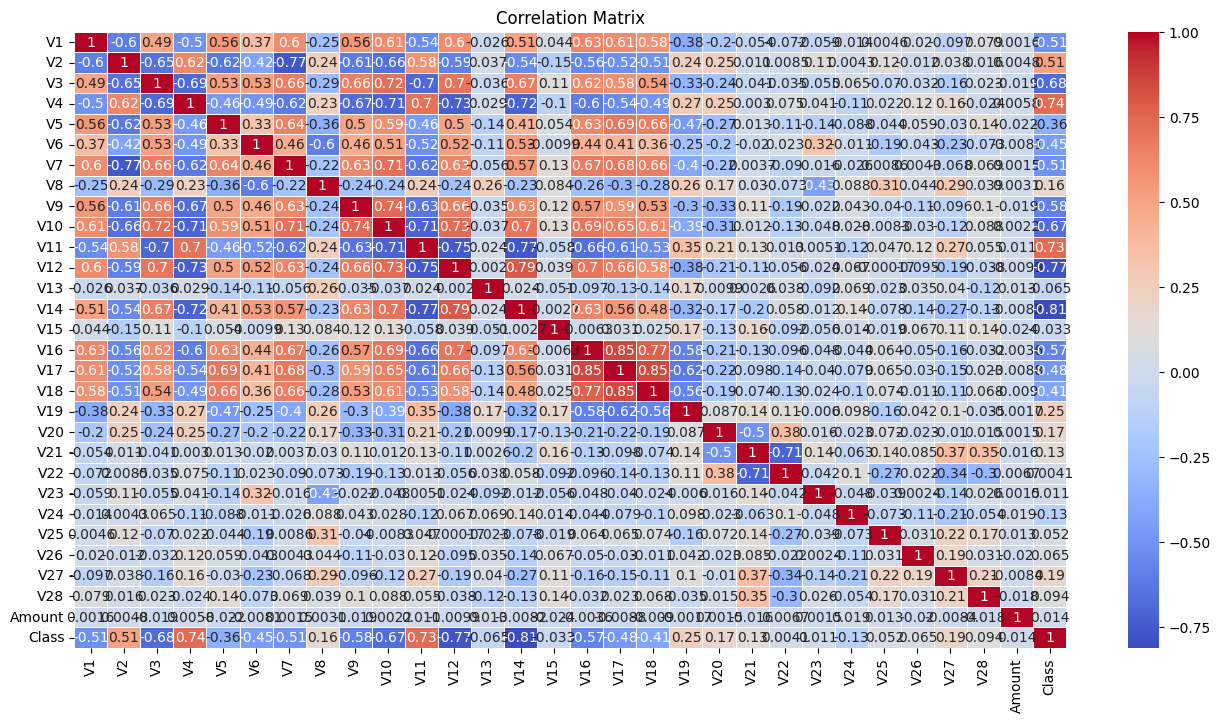

In [29]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Несмотря на наличие сильно кореллирующих признаков, их обфусикация авторами датасета не позволяет провести работу с ними, не повредив датасету.

### Сравнение

In [30]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
train_models()

Model: MyLogisticRegression
Best Params: {'C': 10, 'iter_num': 4000, 'learning_rate': 1.0}
Train Score: 0.9655
Test Score: 0.9640

Model: LogisticRegression
Best Params: {'C': 10, 'solver': 'newton-cg'}
Train Score: 0.9672
Test Score: 0.9605



Result placeholder